# Homework 1
## Advanced Statistical Computing
_Nick Strayer_


In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import gpxpy.geo
import seaborn as sns
sns.set_context('notebook')
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
from IPython.display import HTML

# import basemap
init_notebook_mode(connected=True)

## Question 1

> 1) Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

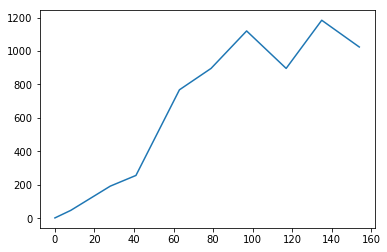

In [2]:
days    = 0, 8, 28,41,  63, 79,  97,117, 135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

### Implementation

To solve this problem I will implement the steepest descent algorithm by hand. I will also compare this to using the built in `fmin` function in `scipy`.


---

__Find Derivatives__


First we will use `sympy` to calculate the derivaives of the model for the two parameters we are looking to optimize: the growth rate, r and carrying capacity, K.


In [3]:
import sympy as sy
N, N0, K, r, t, i, m = sy.symbols('N N0 K r t i m')
error = sy.Sum( ( N - ((K*N0)/ (N0 + ((K - N0)*sy.exp(-r*t))))  )**2 , (i, 0, m))
print("d_K:", sy.diff(error, K))
print("d_r:", sy.diff(error, r))

d_K: (m + 1)*(-K*N0/(N0 + (K - N0)*exp(-r*t)) + N)*(2*K*N0*exp(-r*t)/(N0 + (K - N0)*exp(-r*t))**2 - 2*N0/(N0 + (K - N0)*exp(-r*t)))
d_r: -2*K*N0*t*(K - N0)*(m + 1)*(-K*N0/(N0 + (K - N0)*exp(-r*t)) + N)*exp(-r*t)/(N0 + (K - N0)*exp(-r*t))**2


We can save those derivatives to functions, along with creating functions for calculating the gradient at given parameter values, calculating the sum of squared errors and various small helper functions that will make our life easier.

In [4]:
from math import exp

def logisticFunc(K, r, N0, t) : 
    return (K*N0)/(N0 + (K - N0)*exp(-r*t))

def getPrediction(K, r, times, N0 = 2):
    "Given parameters set will return a vector of predictions for supplied times vector"
    return [logisticFunc(K, r, N0, t) for t in times]

def calcSSE(K, r):
    "Calculates the sum of square error for our logistic model at a given r and K with supplied data"
    preds = getPrediction(K, r, days)
    squaredErrors = [(pred - truth)**2 for (pred, truth) in zip(preds, beetles)]
    return sum(squaredErrors)

def Nd_K(K, r, N0, N, t): 
    "Takes a pair of parameters and returns a function that takes N0, N1, and t to calculate K part of gradient"
    return (-K*N0/(N0 + (K - N0)*exp(-r*t)) + N)*(2*K*N0*exp(-r*t)/(N0 + (K - N0)*exp(-r*t))**2 - 2*N0/(N0 + (K - N0)*exp(-r*t)))

def Nd_r(K, r, N0, N, t): 
    "Takes a pair of parameters and returns a function that takes N0, N1, and t to calculate r part of gradient"
    return -2*K*N0*t*(K - N0)*(-K*N0/(N0 + (K - N0)*exp(-r*t)) + N)*exp(-r*t)/(N0 + (K - N0)*exp(-r*t))**2

def calcGradient(K, r):
    """
    Supplied with r and K will use our data to calculate the 2 element gradient vector
    at our given point in the parameter space
    Returns [dK, dr] 
    """
    N0 = 2
    rk_dK = [Nd_K(K,r,N0,N,t) for (N, t) in zip(beetles, days)]
    rk_dr = [Nd_r(K,r,N0,N,t) for (N, t) in zip(beetles, days)]
    
    return (sum(rk_dK), sum(rk_dr))

def logisticGrowth():
    
    f = lambda K, r: calcSSE(K, r)
    f_prime = lambda K, r : calcGradient(K, r)
    return f, f_prime

First we will plot the data along with an example of some model outputs to make sure everything looks correct. 

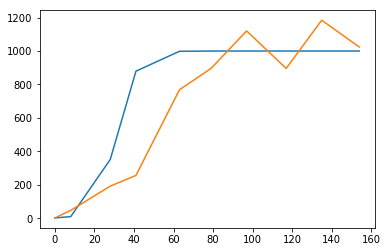

In [6]:
calcSSE
N0 = 2
K = 1000  
r = 0.2
predictions = getPrediction(K, r, days, N0 = 2)
plt.plot(days, predictions)
plt.plot(days, beetles)

We look to have everything in correctly. Next let's plot the sum of squared errors surface over a grid of parameter values to get a sense of the gradient we will be optimizing over.

In [7]:
Kvals  = np.linspace(400, 1600)
rvals  = np.linspace(0, .5)
sse    = np.array([[calcSSE(K,r) for K in Kvals] for r in rvals])
r_grad = np.array([[calcGradient(K,r)[1] for K in Kvals] for r in rvals])/10000
K_grad = np.array([[calcGradient(K,r)[0] for K in Kvals] for r in rvals])

data = [ 
    Surface( x=Kvals, y=rvals, z=sse ),
    ]

layout = Layout(
    title='SSE Surface',
    autosize=True,
    scene = dict(
        xaxis=dict(title='K'),
        yaxis=dict(title='r'),
        zaxis=dict(title='SSE')
    )
    
)
iplot(Figure(data=data, layout=layout))

The surface looks about as we would expect with an apparent minimum at around `K = 1000` and `r = 0.1`. We will use these values as our starting seeds for the gradient descent. 

In an effort to investigate the shape of the gradient let's make a quiver plot of the gradient flows. Note that we are dividing the `r` gradient value by 10,000 in an attempt to even out the magnitudes of the components of the gradient related to `r` and `K`. (More on this in a moment.)

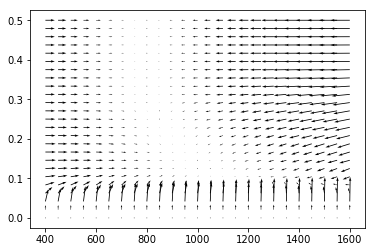

In [8]:
res = 25
Kvals = np.linspace(400, 1600, num = res)
rvals = np.linspace(0, .5, num = res)
r_grad =  -np.array([[calcGradient(K,r)[1] for K in Kvals] for r in rvals])/10000
K_grad =  -np.array([[calcGradient(K,r)[0] for K in Kvals] for r in rvals])


fig, ax = plt.subplots()
ax.quiver(Kvals, rvals, K_grad, r_grad,minshaft = 2)
plt.show()

Again, we see a general trend towards `K = 1000` and `r = 0.1`. Now we will perform steepest descent. The constants for stopping threshold and step size were determined by playing around with different values.

K:1029.9887    r:0.1182     lastSSE:83293.6273    itt:10000


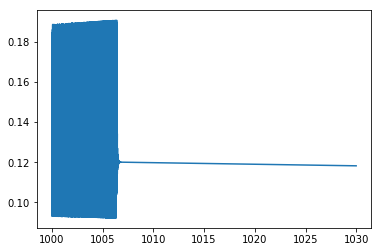

In [22]:
f, f_prime = logisticGrowth()


# sse with given params
SSEThresh = 0.0001
maxIts = 10000
itt = 0
lastSSE = 0
SSE_notconverged = True
step = 0.0000575
K = 1000
r = 0.1

kHist = [K]
rHist = [r]
while SSE_notconverged and itt < maxIts:
    
    curSSE = calcSSE(K,r)
    dK, dr = calcGradient(K, r)

    # scale the magnitude of the changes by the size of their respective params
    rtoK = K/r
    dK_s = dK
    dr_s = dr/rtoK
    
    K -= step*dK_s
    r -= step*dr_s
    kHist.append(K)
    rHist.append(r)

    SSE_notconverged = abs(curSSE - lastSSE)  > SSEThresh
    lastSSE = curSSE
    itt += 1

print('K:%4.4f    r:%4.4f     lastSSE:%4.4f    itt:%3.0f' % (K, r, curSSE, itt))
plt.plot(kHist, rHist)

So we see a large quantity of back and fourth behavior at the begining (left side) followed by a straight shot to our final estimate. This is caused by the trough-like shape of the loss surface. Steepest descent is very bad at handling these trough shapes as it ends up just bouncing up and down either side and if the stepsize is too large, can pop out of the downward gradient and diverge. It took a lot of tweaking to get the results above, which indicates that the algorithm is a very bad drop-in solution to these optimizations. 

We can compare this to the results that we get from using the derivative-free Nelder-Mead  algorithm: 

In [24]:
from scipy import optimize
nm_output = optimize.fmin(
    lambda x: calcSSE(K = x[0], r = x[1]), 
    [1000,0.1], 
    ftol=1e-12)

nm_output

Optimization terminated successfully.
         Current function value: 83240.486583
         Iterations: 99
         Function evaluations: 228


array([  1.03351533e+03,   1.17958557e-01])

Unsurpisingly, Nelder-Mead works much better. It is generally more robust to the trough-shaped loss surfaces and, even though it has to calculate the derivative by finite-differencing, still used an order of magnitude less function evaluation than our home-spun steepest-descent attempt. 

---
> 2) In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

First we will setup our data into the proper form by log-transforming it. We then setup an objective function `calcLogLikelihood` that will take the three parameters we wish to estimate `K, r` and $\sigma^2$ and return the negative log likelihood (or at least a function proportional to it). 

In [27]:
from math import log, pi

logBeetles = [log(b) for b in beetles]
logGrowth = lambda K, r, t: log(logisticFunc(K, r, 2, t))

def calcLogLikelihood(x):
    "Returns the overall loglikelihood according to the log-normal model for our data"
    K, r, variance = x
    if variance < 0: return 1e10 # hacky way to protect against exploring negative variances
    likelihoods = [
        log(2/pi) - log(variance) - (1/variance)*(observed - logGrowth(K, r, t))**2
        for (observed, t) in zip(logBeetles, days)
    ]
    loglik = -sum(likelihoods)
    return loglik

From here all we need to do is pass this into `scipy.optimize.minimize`. This will perform Nelder-Mean optimization again, but will also return estimates of the jacobian and hessian matrix to allow us to learn about the covariance structure between the parameters as well.

In [28]:
mle_output = optimize.minimize(
    calcLogLikelihood,
    (1000,0.1,5)
)
mle_output

      fun: 3.8226775251787877
 hess_inv: array([[  9.90107036e+03,  -5.27365414e-03,   9.72810291e-02],
       [ -5.27365414e-03,   3.38905737e-03,   7.76940723e-05],
       [  9.72810291e-02,   7.76940723e-05,   1.25454335e-02]])
      jac: array([ -1.19209290e-07,  -1.37090683e-06,  -8.94069672e-08])
  message: 'Optimization terminated successfully.'
     nfev: 275
      nit: 30
     njev: 55
   status: 0
  success: True
        x: array([  6.72092139e+02,   4.00460856e-01,   3.43243567e-01])

---

## Question 2

> 1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

First we load in the data and copy out a set of predictors and log the salary as in class.

In [29]:
baseball = pd.read_table('../data/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)

Next we define a few function to help us in the next few parts.

In [30]:
from sklearn.linear_model import LinearRegression

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

def calculateAIC(current_selection, predictors, outcome):
    solution_vars = predictors[predictors.columns[current_selection]]
    g = LinearRegression().fit(X=solution_vars, y=outcome)
    return aic(g, solution_vars, logsalary)

def newSelection(current_selection, numNeighborhood = 1):
    new_selection = current_selection.copy()
    for i in range(numNeighborhood):
        flip = np.random.randint(0, len(new_selection))
        new_selection[flip] = not new_selection[flip]
    return new_selection

def moveToNew(newAIC, lastAIC, tau):
    alpha = min(1, np.exp((lastAIC - newAIC)/tau))
    return (newAIC < lastAIC) or (np.random.uniform() < alpha)

def simulatedAnnealing(coolingFunc, numSteps, neighborhood, predictors, outcome):
    cooling_schedule = [coolingFunc(step) for step in range(numSteps)]
    nrows, ncols = predictors.shape

    current_selection = best_selection = np.random.binomial(1, 0.5, ncols).astype(bool)
    current_aic = best_aic = calculateAIC(current_selection, predictors, outcome)
    aic_values = [current_aic]

    for tau in cooling_schedule:
        new_selection = newSelection(current_selection, numNeighborhood = 1)
        new_aic = calculateAIC(new_selection, predictors, outcome)
        # decide if we should take the new proposed solution
        move_to_new = moveToNew(new_aic, current_aic, tau)
        # if we move to the new solution, reset our current selection to the new one.
        if(move_to_new):
            current_selection = new_selection
            current_aic = new_aic
            if(new_aic < best_aic):
                best_aic = new_aic
                best_selection = new_selection
        
        # record our decided on model's aic
        aic_values.append(current_aic)

    return (best_selection, np.array(aic_values))

In [32]:
def plotSimAnnealResults(aic_values, solution_best, verbose = False): 
    lowest_aic = aic_values.min()
    plt.plot(aic_values)
    plt.xlim(0, len(aic_values))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    plt.title('Lowest AIC %3.3f' % lowest_aic)
    if(verbose):
        print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(solution_best, 
                    np.where(solution_best==True),
                    np.where(aic_values==lowest_aic)[0][0]))
    plt.plot(np.where(aic_values==lowest_aic)[0][0], lowest_aic, 'ro')

> 1a. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  

To compare the results of many different cooling functions we will wrap the results plotting code from the lecture into a function and feed a bunch of different cooling functions to it to compare results. 

First we will look at performance for the function $$\tau(i) = \frac{10}{i + 1}$$

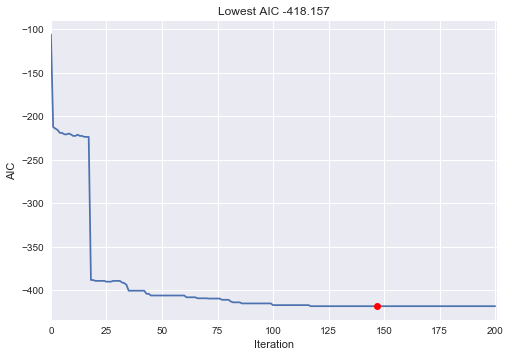

In [101]:
numSteps = 200
coolingFunc1 = lambda step: 10 * (1/(step + 1))
best_solution, aics = simulatedAnnealing(coolingFunc1, numSteps, 1, predictors, logsalary)
plotSimAnnealResults(aics, best_solution)

Next we will try a linear slowdown:
$$\tau(i) = 10 \cdot \frac{\text{max #} - i}{\text{max #}}$$

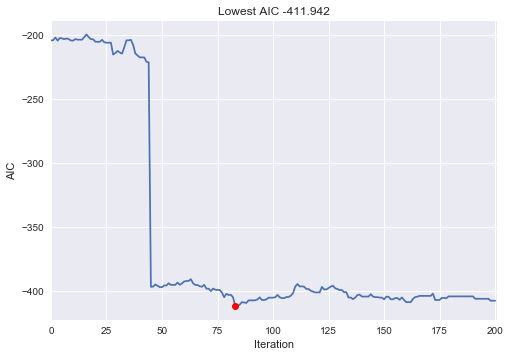

In [102]:
coolingFunc2 = lambda step: 10 * (numSteps - step)/(numSteps)
best_solution2, aics2 = simulatedAnnealing(coolingFunc2, numSteps, 1, predictors, logsalary)

plotSimAnnealResults(aics2, best_solution2)

Next we will try a more traditional stepdown approach

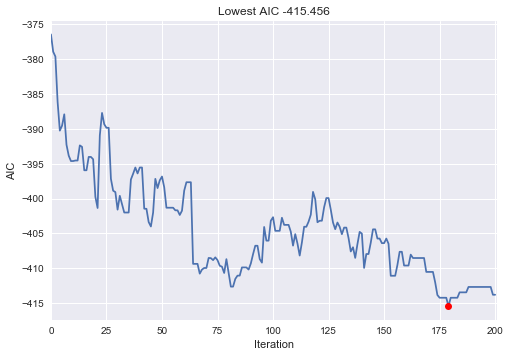

In [103]:
def coolingFunc3(step):
    if step < numSteps/5:
        return 10
    elif step < 2*numSteps/5:
        return 7
    elif step < 3*numSteps/5:
        return 5
    elif step < 4*numSteps/5:
        return 3
    else:
        return 1
    
best_solution3, aics3 = simulatedAnnealing(coolingFunc3, numSteps, 1, predictors, logsalary)
plotSimAnnealResults(aics3, best_solution3)

Lastly we will try the stepdown format but this time spending successively longer time for smaller temperatures as is recomended.

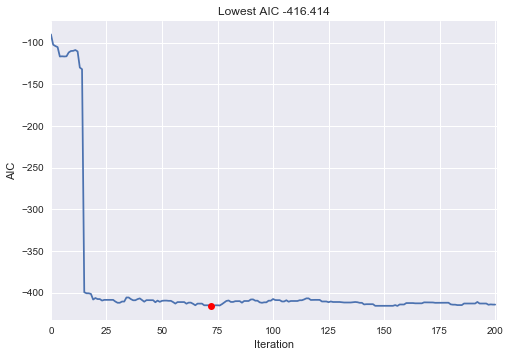

In [105]:
def coolingFunc4(step):
    if   step < 1*numSteps/15:
        return 10
    elif step < 2*numSteps/15:
        return 7
    elif step < 4*numSteps/15:
        return 5
    elif step < 8*numSteps/15:
        return 3
    else:
        return 1
    
best_solution4, aics4 = simulatedAnnealing(coolingFunc4, numSteps, 1, predictors, logsalary)
plotSimAnnealResults(aics4, best_solution4)

Since the algorithm is stochastic a better way to compare the different cooling schedules is to compare average best aic scores over multiple runs. 

In [38]:
def averageAIC(coolingFunc, numRuns = 10, neighborhood = 1):
    best_aics = []
    for i in range(numRuns):
        _, aics = simulatedAnnealing(coolingFunc, numSteps, neighborhood, predictors, logsalary)
        best_aics.append(min(aics))
    return np.mean(best_aics)

In [39]:
num_runs = 20
cooling1_avg = averageAIC(coolingFunc1, numRuns = num_runs)
cooling2_avg = averageAIC(coolingFunc2, numRuns = num_runs)
cooling3_avg = averageAIC(coolingFunc3, numRuns = num_runs)
cooling4_avg = averageAIC(coolingFunc4, numRuns = num_runs)

/Users/nick/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in exp



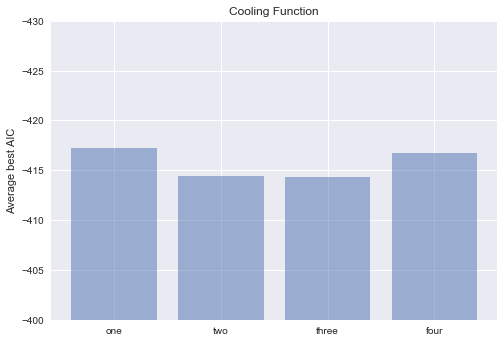

In [100]:
objects = ('one', 'two', 'three', 'four')
y_pos = np.arange(len(objects))
performance = [cooling1_avg,cooling2_avg,cooling3_avg,cooling4_avg]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim((-400,-430))
plt.ylabel('Average best AIC')
plt.title('Cooling Function')
 
plt.show()

So all of the investigated cooling functions worked similarly, with a slight edge to the first one. 

---

> 1b. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

To do this we will select the best cooling schedule from above (the first one) and compare the average best aic for both 2 and 3 neighborhood searches.

In [43]:
one_neighborhood_avg   = averageAIC(coolingFunc1, numRuns = num_runs, neighborhood = 1)
two_neighborhood_avg   = averageAIC(coolingFunc1, numRuns = num_runs, neighborhood = 2)
three_neighborhood_avg = averageAIC(coolingFunc1, numRuns = num_runs, neighborhood = 3)

/Users/nick/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in exp



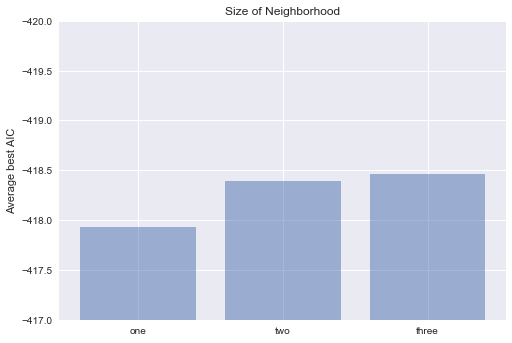

In [106]:
objects = ('one', 'two', 'three')
y_pos = np.arange(len(objects))
performance = [one_neighborhood_avg, two_neighborhood_avg,three_neighborhood_avg]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim((-417,-420))
plt.ylabel('Average best AIC')
plt.title('Size of Neighborhood')
 
plt.show()

So we see that the three neighborhood search on average out performs the both two and one. The difference however is very small (not the truncated y-axis on the graph.) 

---

> 2) Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

First we define functions to help us out. 

In [79]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def geneticOptimize(numIterations, populationSize, mutationRate, predictors, outcome, bothWeighted = False):
    best_aic = []
    best_solution = []
    aic_history = []
    
    nrows, ncols = predictors.shape
    
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, populationSize*ncols).reshape((populationSize, ncols))

    for i in range(numIterations):

        # Get data (phenotypes) for each genotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]

        # Calculate AIC for each phenotype
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=outcome), x, logsalary) for x in current_phe])

        # Get lowest AIC
        best_aic.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness. More likely to choose 'fitter' phenotypes
        moms = np.random.choice(range(populationSize), size=int(populationSize/2), p=fitness)

        # Choose second parents randomly
        if bothWeighted:
            dads = np.random.choice(range(populationSize), size=int(populationSize/2), p=fitness)
        else:
            dads = np.random.choice(range(populationSize), size=int(populationSize/2))

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover location
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutationRate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutationRate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)

        # Store AIC values
        aic_history.append(current_aic)
        
    return (best_aic, best_solution, aic_history)

In [112]:
# some plotting helpers
def makeLegend(vals, title, colorPal = lineColors):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    legendMarkers = [
        mpatches.Patch(color=colorPal[i], label=val) for
        i, val in enumerate(vals)
    ]
    legend = plt.legend(title = title, handles=legendMarkers, fontsize = 'x-large')
    legend.get_title().set_fontsize('20')
    
titleStyle = {
    'fontsize': 27,
    'fontweight' : 'bold',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}

axesStyle = {
    'fontsize': 18,
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
}

lineColors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
              '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

> 2a) Compare the effects of using different mutation rates.

In [80]:
nIts = 100
nPop = 20
mutationRates = [0.01, 0.02, 0.03, 0.1, 0.2]
aicByMutationRate = [
    best_aic for (best_aic, best_sol, aic_hist) in [
        geneticOptimize(nIts, nPop, rate, predictors, logsalary) for rate in mutationRates
    ]
]

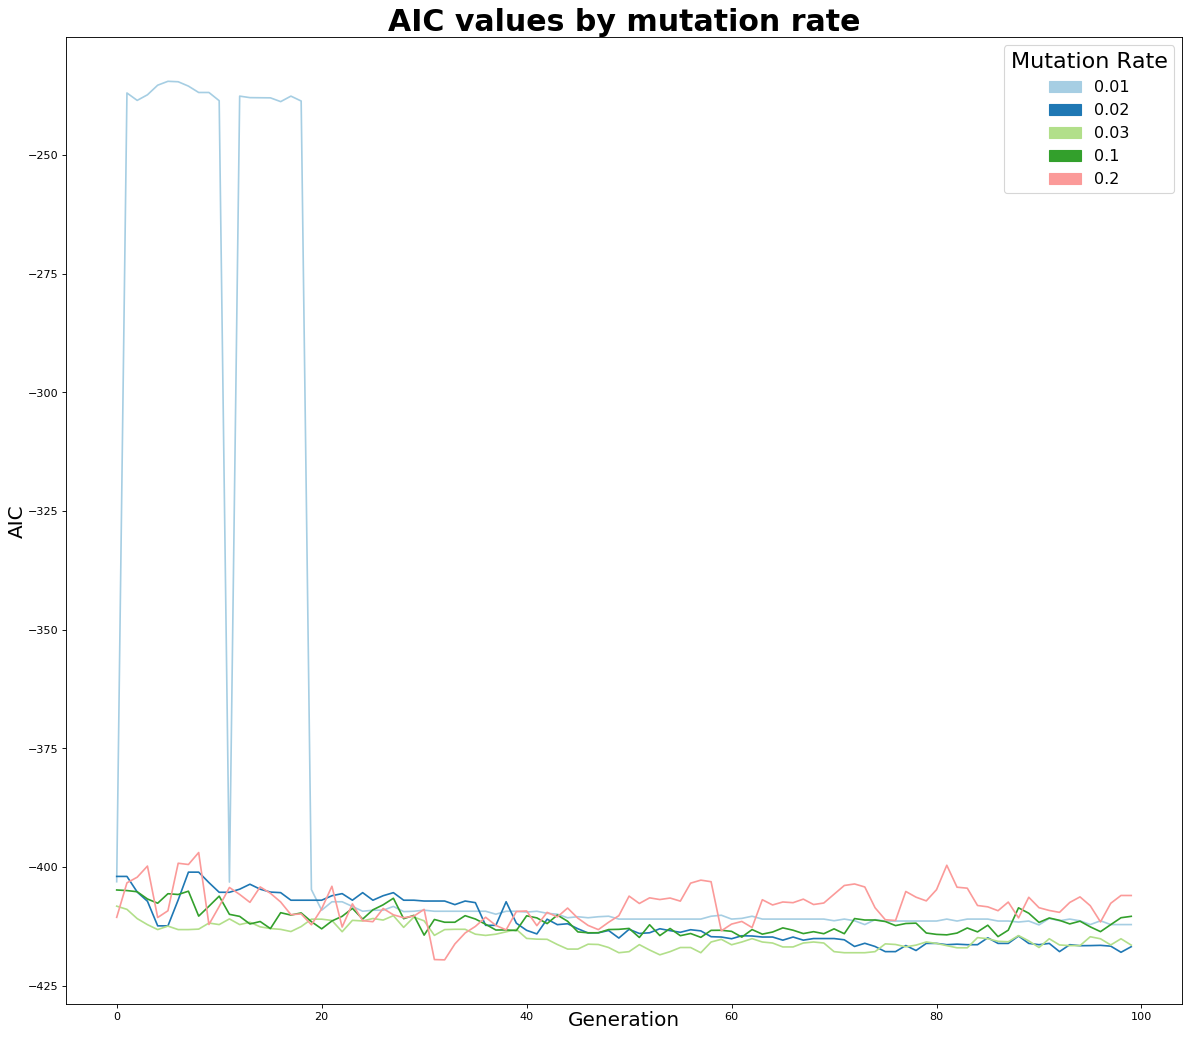

In [81]:
x = range(nIts)
mutationRates = [0.01, 0.02, 0.03, 0.1, 0.2]
makeLegend(mutationRates, "Mutation Rate")
for i, rate in enumerate(mutationRates):
    plt.plot(x, aicByMutationRate[i], '-r', color = lineColors[i])
plt.title("AIC values by mutation rate", fontdict = titleStyle)
plt.xlabel("Generation", fontdict = axesStyle)
plt.ylabel("AIC", fontdict = axesStyle)
plt.show()

So from the above plot we can see that the super low mutation rates (0.01, 0.02) get stable very quickly. The very high mutation rates (0.1, 0.2) improve slightly but never seem to really catch on to a good design and stay highly variable. The middle rate (0.03) seems to find a good balance between stabilizing to a good solution, while still having a high enough mutation to find even better results

> 2b) Compare the effects of using different generation sizes.  

In [82]:
nIts = 100
muteRate = 0.03
genSizes = [10, 20, 50, 100, 250]
aicByGenSize = [
    best_aic for (best_aic, best_sol, aic_hist) in [
        geneticOptimize(nIts, size, muteRate, predictors, logsalary) for size in genSizes
    ]
]

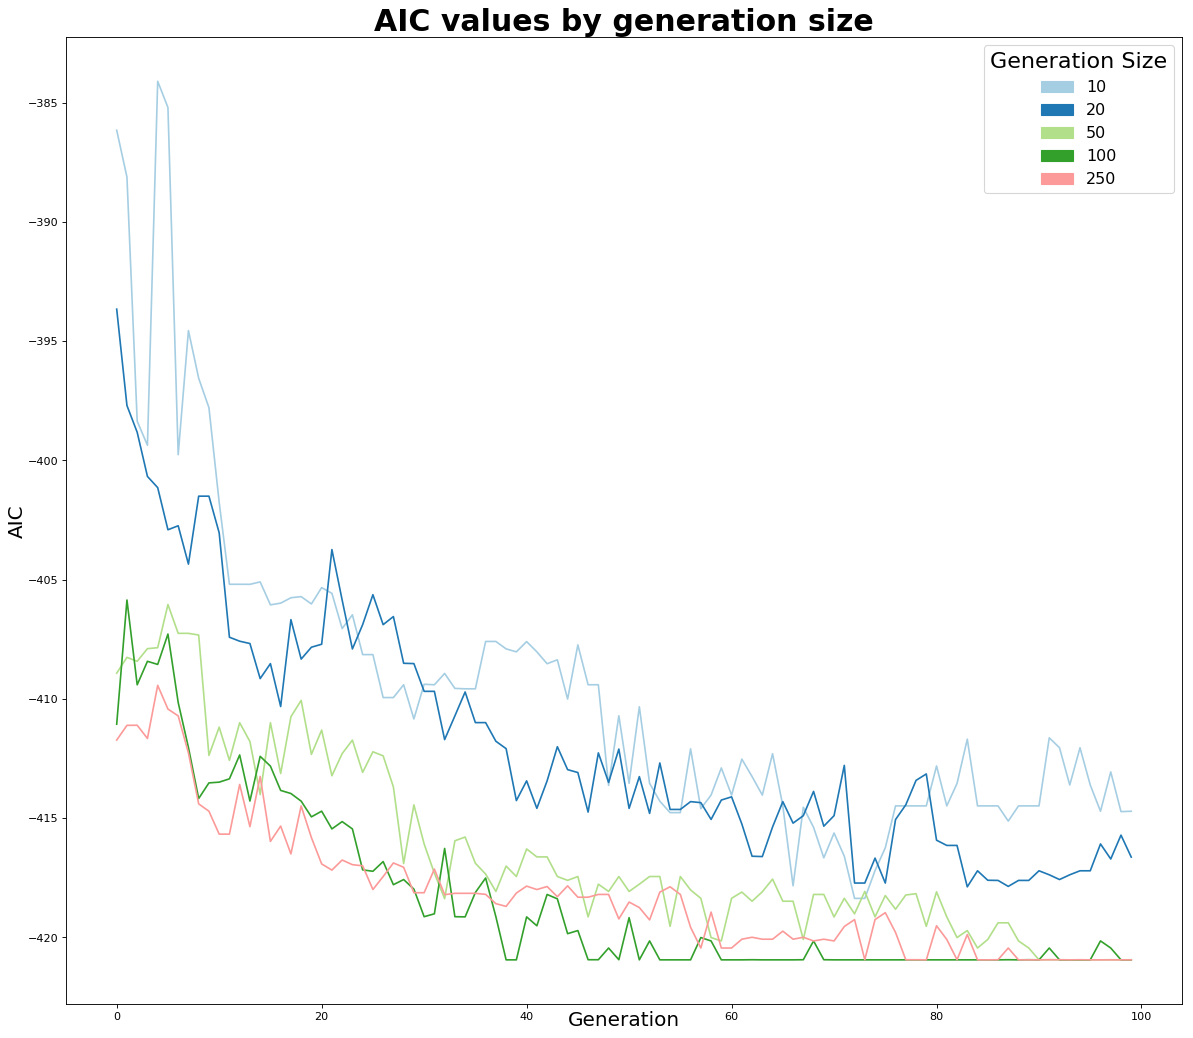

In [83]:
makeLegend(genSizes, "Generation Size")
for i, size in enumerate(genSizes):
    plt.plot(x, aicByGenSize[i], '-r', color = lineColors[i])
plt.title("AIC values by generation size", fontdict = titleStyle)
plt.xlabel("Generation", fontdict = axesStyle)
plt.ylabel("AIC", fontdict = axesStyle)
plt.show()

Unlike with the mutation rate we see a consistant improvement as we increase our generation size. This makes sense as a larger generation population leads to a greater number of possible solutions explored.

> 2c) Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.

In [84]:
nIts = 100
muteRate = 0.03
genSize = 50
weighted = [True,True,True,True,True,False,False,False,False,False]
aicByWeightScheme = [
    best_aic for (best_aic, best_sol, aic_hist) in [
        geneticOptimize(nIts, genSize, muteRate, predictors, logsalary, bothWeighted) for bothWeighted in weighted
    ]
]

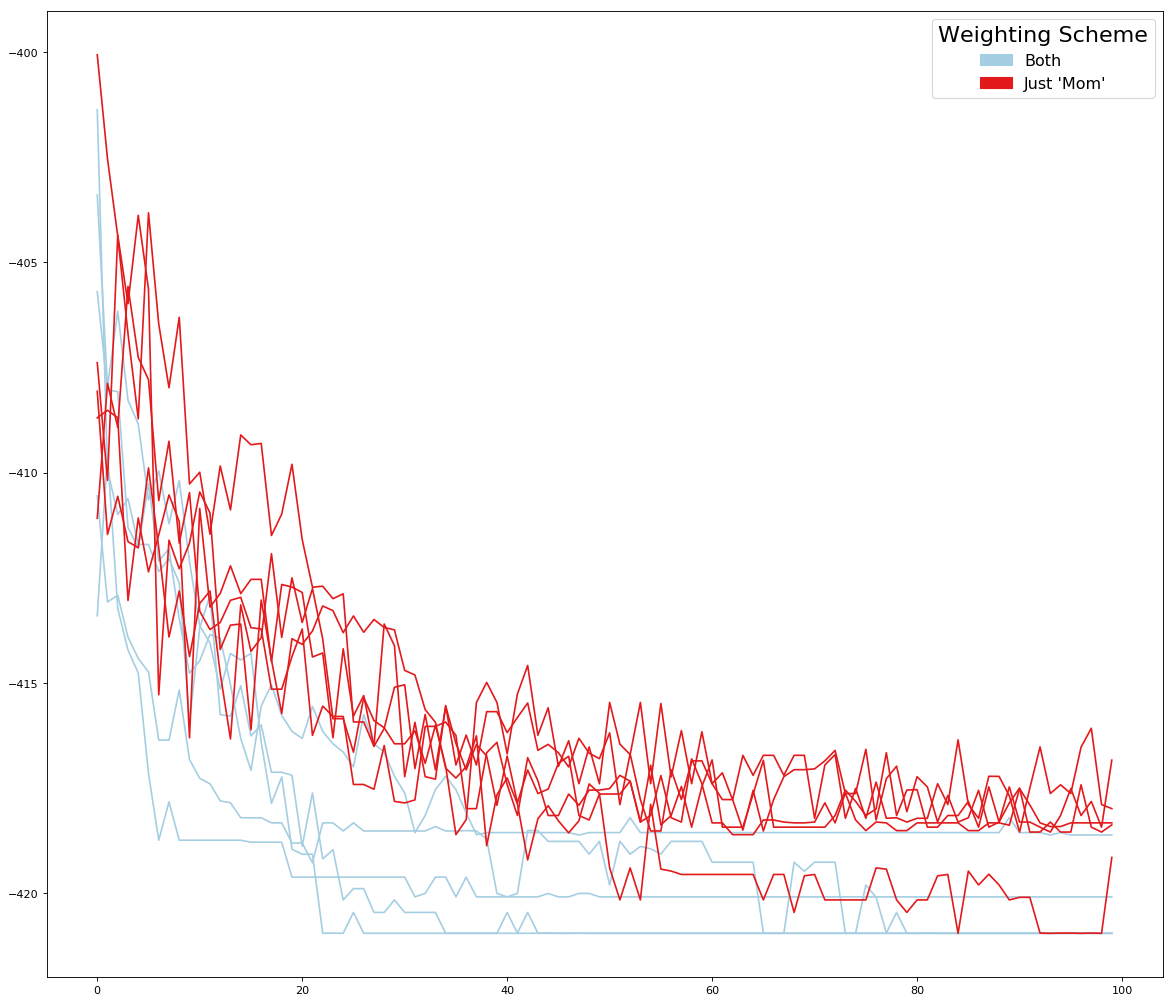

In [85]:
makeLegend(["Both", "Just 'Mom'"], "Weighting Scheme", colorPal = [lineColors[0], lineColors[5]])
for i, bothWeighted in enumerate(weighted):
    aics = aicByWeightScheme[i]
    color = lineColors[0] if bothWeighted else lineColors[5]
    plt.plot(x, aics, '-r', color = color)
plt.show()

We see that on average the weighting scheme where just the 'mom' genotype is selected based on fitness seems to perform worse than if both are. This most likely is due to the inclusion of poorly performing genomes, while good for exploring new decision spaces seems to on average mess up well performing solutions. This is evidenced by the fact there are a lot more inclines, or subsequent generation being 'worse' than the previous in the `just mom` groups than in the ones where both parents are preferentially chosen by fitness.

---

## Question 3

> Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). 

In [96]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

In [ ]:
# %load_ext cython

In [107]:
from functools import lru_cache

def makeRoute(numCities = 26):
    """
    Takes a given number of cities and makes a random route 
    between them starting and ending at the first city
    """
    innerRoute = np.random.permutation(np.arange(1, numCities))
    return np.concatenate(([0], innerRoute, [0]))

def npIndex(arr, el): 
    "Small helper to get the first location in numpy array of a given element"
    np.where(arr == el)[0][0]

def breedRoutes(routeOne, routeTwo, mutationRate = 0.01):
    """
    Takes a two routes represented as a numpy vector [0, 4, 6, ..., 0]
    and breeds them together to create a new route. 
    All points where the routes differ are swaped with 50% chance to the 
    offspring. 
    In addition to swapping of position a binomial random draw is made to 
    decide how many random mutation are incurred in the route according to the
    mutation rate. 
    """
    swapProb = 0.5
    newRoute = routeOne.copy()
    swaps = [[one, two] for (one, two) in zip(routeOne, routeTwo) if one != two]

    for swap in swaps:
        if np.random.binomial(1, swapProb) == 1:
            firstInd  = npIndex(newRoute,swap[0])
            secondInd = npIndex(newRoute,swap[1])
            newRoute[firstInd], newRoute[secondInd] = newRoute[secondInd], newRoute[firstInd]
    
    # see how many random mutations we get. 
    numRandMutation = np.random.binomial(n = len(routeOne) - 2, p = mutationRate)
    for i in range(numRandMutation):
        firstInd  = np.random.randint(low = 1, high = len(routeOne) - 2)
        secondInd = np.random.randint(low = 1, high = len(routeOne) - 2)
        newRoute[firstInd], newRoute[secondInd] = newRoute[secondInd], newRoute[firstInd]
    return newRoute


# @lru_cache(maxsize=None)
def distanceApart(city1, city2):
    """
    Calculate distance between two given cities using the Haversine distance.
    This assumes that the world is perfectly sphearicle which is obviously false
    But given the relatively small geographical range of our cities is an
    acceptable simplification.
    """
    c1Lat, c1Lon = cities.iloc[city1]
    c2Lat, c2Lon = cities.iloc[city2]
    dist = gpxpy.geo.haversine_distance(c1Lat, c1Lon, c2Lat, c2Lon)
    return dist

def citiesToString(city1, city2):
    return "%i_%i" % (city1, city2)

def citiesFromString(cityPath):
    cities = cityPath.split("_")
    city1 = int(float(cities[0]))
    city2 = int(float(cities[1]))
    return city1, city2

@lru_cache(maxsize=None)
def distanceApartMemo(cityPath):
    city1, city2 = citiesFromString(cityPath)
    return distanceApart(city1, city2)

# @lru_cache(maxsize=None)
def routeLength(route):
    """
    Takes a route in the numpy array form and returns the total distance traveled
    Units are kilometers, uses the distanceApart function above and thus the 
    Haversine distance as well.
    """
    # Make an offset array to create paths with
    toArray = np.concatenate(([0], route))
    # Memoized version
    routeSteps = [distanceApartMemo(citiesToString(city1, city2)) for (city1, city2) in zip(toArray, route)][1:]
    # return the summed distances
    return sum(routeSteps)

def calcFitness(routeLengths):
    P = len(routeLengths)
    lengthRank = (-np.array(routeLengths)).argsort().argsort()+1.
    return 2.*lengthRank/(P*(P+1.))

def mutatingSalesman(generationSize, numberGenerations, mutationRate):
    bestHistory = []
    routeHistory = []
    bestDistance = 1e20
    currentGen  = np.array([makeRoute() for _ in range(generationSize)])

    for _ in range(numberGenerations):

        routeLengths = [routeLength(route) for route in currentGen]
        shortestRouteInd = np.argmin(routeLengths)
        shortestInGen = routeLengths[shortestRouteInd]
        routeHistory.append(currentGen[shortestRouteInd])
        
        if(shortestInGen < bestDistance):
            bestDistance = shortestInGen
            bestRoute = currentGen[shortestRouteInd]
        
        bestHistory.append(shortestInGen)
        routeFitness = calcFitness(routeLengths)

        # Choose first parents according to fitness. More likely to choose 'fitter' phenotypes
        moms = np.random.choice(range(generationSize), size=int(generationSize/2), p = routeFitness)
        dads = np.random.choice(range(generationSize), size=int(generationSize/2))

        # Create two batches of children 
        children1 = [breedRoutes(mom, dad, mutationRate) for mom,dad in zip(currentGen[moms], currentGen[dads])]
        children2 = [breedRoutes(mom, dad, mutationRate) for mom,dad in zip(currentGen[moms], currentGen[dads])]

        # Merge batches together to form the new generation
        currentGen = np.concatenate((children1, children2))
        
    return bestDistance, bestRoute, bestHistory, routeHistory

Lets now investigate the effect of a different mutation rates:

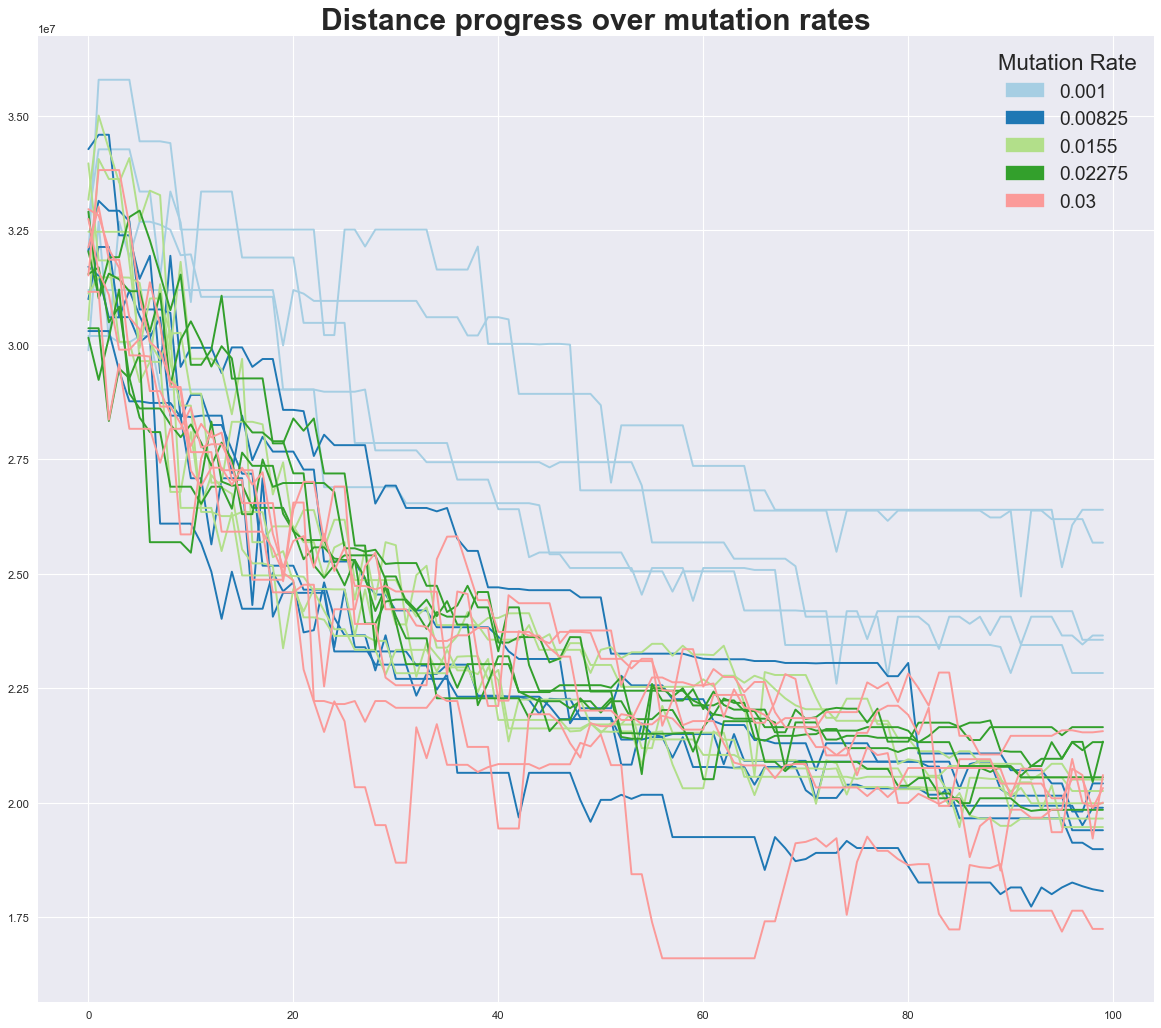

In [114]:
generationSize = 70
numberGenerations = 100
numRates = 5
repeats = 5

x = range(numberGenerations)

mutationRates = np.linspace(start = 0.001, stop = 0.03, num = numRates)
makeLegend(mutationRates, "Mutation Rate")

for i, rate in enumerate(mutationRates):
    for _ in range(repeats):
        _, _, bestHistory, _ = mutatingSalesman(generationSize, numberGenerations, rate)
        plt.plot(x, bestHistory, '-r', color = lineColors[i])

plt.title("Distance progress over mutation rates", fontdict = titleStyle)
plt.show()

So we can see that the optimal mutation rate in this situation seems to be between 0.015 and 0.020, but all values above the smallest 0.001 seem to perform decently well. For the remainder of the tests we will fix our mutation rate at 0.0175.

---

Next, the effect of generation size:

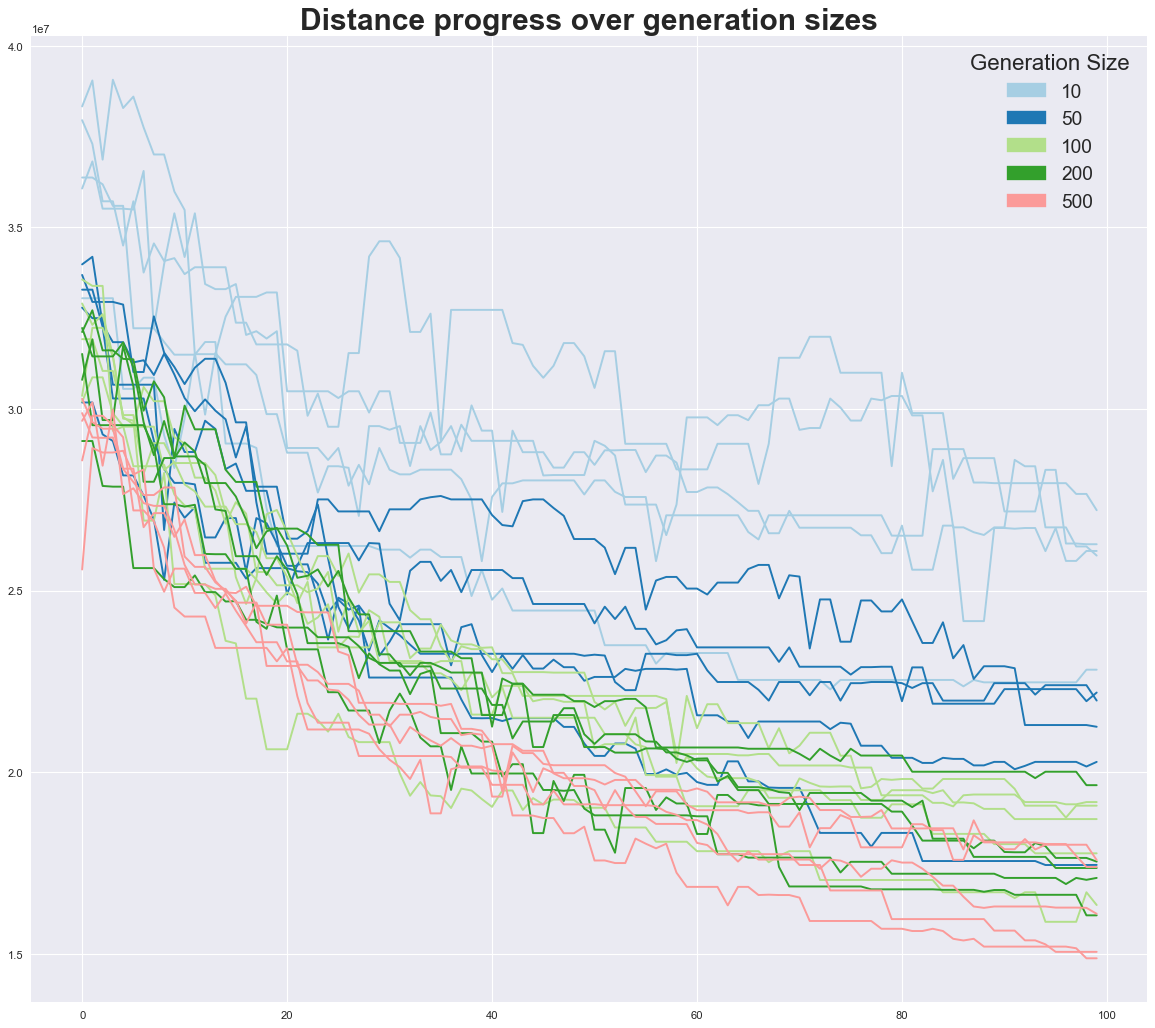

In [115]:
mutationRate = 0.0175
genSizes = [10, 50, 100, 200, 500]
makeLegend(genSizes, "Generation Size")
for i, size in enumerate(genSizes):
    for _ in range(repeats):
        _, _, bestHistory, _ = mutatingSalesman(size, numberGenerations, mutationRate)
        plt.plot(x, bestHistory, '-r', color = lineColors[i])
        
plt.title("Distance progress over generation sizes", fontdict = titleStyle)
plt.show()

So we seem to get better as size increases but basically after 50 there is not a huge difference in performance on average. To be conservative we will set the generation size to 500. 

---

Lastly, we will combine the two best results from the the mutation amount and generation size and run a bunch of simulations to see how good we can do.

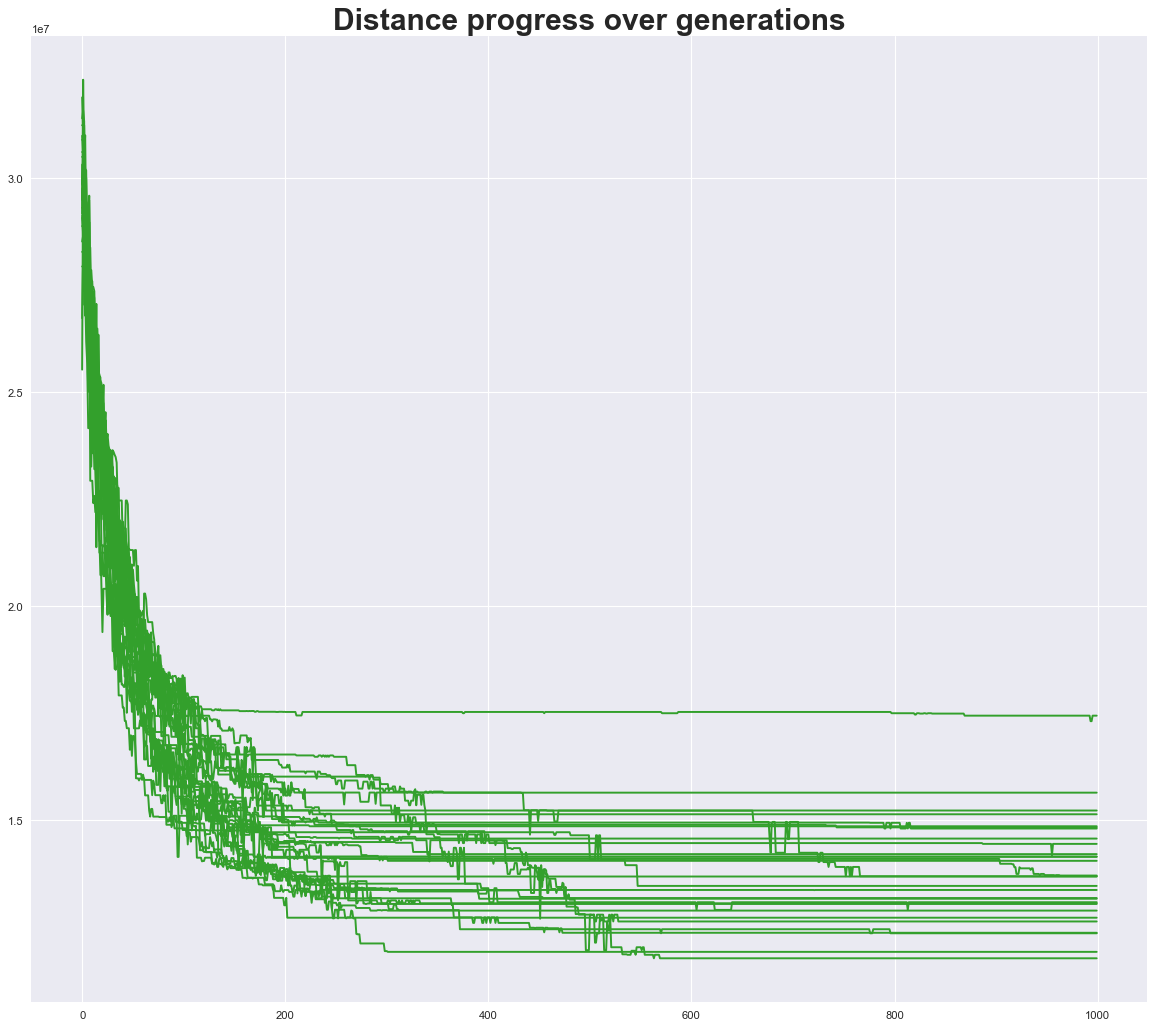

In [126]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

mutationRate = 0.02
numberGenerations = 1000
numRuns = 30
gen = range(numberGenerations)

bestDistance = 1e20

for i in range(numRuns):
    dist, route, bestHistory, routeHistory = mutatingSalesman(generationSize, numberGenerations, mutationRate)
    plt.plot(gen, bestHistory, '-r', color = lineColors[3])
    
    if(dist < bestDistance):
        bestRoute = route
        bestDistance = dist
        bestRH = routeHistory

plt.title("Distance progress over generations", fontdict = titleStyle)
plt.show()

So we see roughly the behaviour we would expect. Next we can look at the route that our algorithm actually came up with.

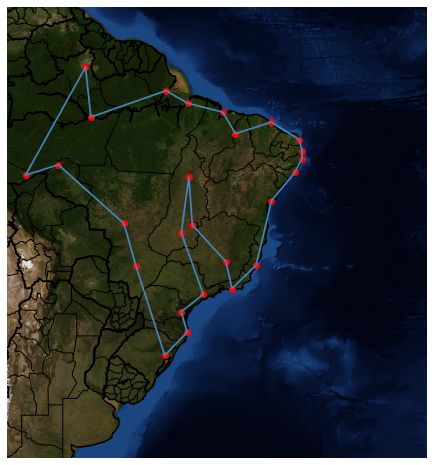

In [127]:
xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0

fig = plt.figure(figsize=(11.7,8.3))
bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
bm.drawcoastlines(linewidth=1.5)
bm.bluemarble()
bm.drawcountries(linewidth=2)
bm.drawstates(linewidth=1)

for i,c in cities.iterrows():
    bm.plot(-c['lat'], c['lon'], 'ro', latlon=True)
    
pathLats = [-cities.iloc[city][0] for city in bestRoute]
pathLons = [cities.iloc[city][1] for city in bestRoute]

bm.plot(pathLats, pathLons, color = 'steelblue', latlon=True)

While perhaps not exactly the best, it seems to be at least working in some sense. To get an idea of how the algorithm progresses through the generations we can plot the progress as illustrated by the best found path at each generation. 

In [132]:
xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0

fig = plt.figure(figsize=(11.7,8.3))
bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
bm.drawcoastlines(linewidth=1.5)
bm.bluemarble()
bm.drawcountries(linewidth=2)
bm.drawstates(linewidth=1)

for i,c in cities.iterrows():
    bm.plot(-c['lat'], c['lon'], 'ro', latlon=True)

i = 0
curRoute = bestRH[i]
pathLats = [-cities.iloc[city][0] for city in curRoute]
pathLons = [ cities.iloc[city][1] for city in curRoute]
routePath = bm.plot(pathLats, pathLons, color = 'steelblue', linestyle='dashed', linewidth = 2, latlon=True)[0]

def init():
    routePath.set_data([], [])
    return routePath,

# animation function.  This is called sequentially
def animate(i):
    curRoute = bestRH[i]
    pathLats = [-cities.iloc[city][0] for city in curRoute]
    pathLons = [ cities.iloc[city][1] for city in curRoute]
    x, y = bm(pathLats, pathLons)
    routePath.set_data(x, y)
    return routePath,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=575, interval=50)
plt.close()

<video controls src="/homework/files/travelingSalesman.mp4" />

## Question 4

> The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

> From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

Again, we start with a bunch of helper function. In order to deal with differeing column names for both the type of data reported and the actual counts we create a list of the seen column titles for each and then find the union between what is in a given dataframe and what we know of. This makes the function easy to expand to new datasets. If for instance a new country is added that uses a different nomenclature it can simply be added by adding an entry to the list of known ways of refering to the column. 

In addition, the method of choosing the row of interest was done pessemistically. For new cases we selected the row that was had in its title some combination of "new" and "cases" and if there were multiple columns, we took the largest. The same process was used for deaths, in this case searching for the terms "new" and "death". For countries that did not issue national values for their deaths a sum of the individual locations death counts was computed. `NaN` values are for instances where there was no reported data in the required categories.

In [134]:
import os.path
import re
def listDirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

def extractCountry(dirName):
    return dirName.replace("_data", "")

def extractDate(fileName):
    return re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', fileName)[0]

def getColMax(col):
    return pd.to_numeric(col).max()

def findTypeColumn(data):
    typeColumns = ["Description", "Variable", "variable"]
    columnTitles = list(data.columns.values)
    #get intersection with known type column names
    return list(set(typeColumns) & set(columnTitles))[0]

def findValueColumn(data):
    valColumns = ["Totals", "National"]
    columnTitles = list(data.columns.values)
    #get intersection with known type column names
    return list(set(valColumns) & set(columnTitles))[0]

def getCaseDeaths(filePath):
    data = pd.read_csv(filePath)
    typeColumn = findTypeColumn(data)
    valColumn = findValueColumn(data)

    newCasesRows = data[typeColumn].str.contains("new.*case|case.*new|new.*confirmed|confirmed.*new", case = False)
    # select the highest value in the new cases columns
    numNewCases = getColMax(data[newCasesRows][valColumn])
    newDeathsRows = data[typeColumn].str.contains("new.*death|death.*new", case = False)
    numNewDeaths = getColMax(data[newDeathsRows][valColumn])
    if pd.isnull(numNewDeaths):
        # sometimes there are deaths recorded for locations but not the whole country
        # When we get this we will estimate total new deaths by summing the columns present
        numNewDeaths = (data[newDeathsRows]
                        .apply(pd.to_numeric, errors='ignore')
                        .sum(axis = 1)
                    .max())
    return numNewCases, numNewDeaths

In [135]:
dataPath = '../data/ebola'
countryDirs = listDirs(dataPath)

# initialize a dataframe to store all the extracted info
allData = pd.DataFrame(columns=["country", "date", "new_cases", "new_deaths"])

for countryDir in countryDirs:
    countryPath = dataPath+ "/" +countryDir
    for dayFile in os.listdir(countryPath):
        newCases, newDeaths = getCaseDeaths(countryPath + "/" + dayFile)
        allData = allData.append({
            "country": extractCountry(countryDir),
            "date": extractDate(dayFile),
            "new_cases": newCases,
            "new_deaths": newDeaths
        }, ignore_index=True)

In [136]:
allData.head()

,country,date,new_cases,new_deaths
0,guinea,2014-08-04,9,2
1,guinea,2014-08-26,28,5
2,guinea,2014-08-27,22,2
3,guinea,2014-08-30,24,5
4,guinea,2014-08-31,46,3


In [137]:
allData.tail()

,country,date,new_cases,new_deaths
220,sl,2014-12-01,142,0
221,sl,2014-12-04,116,3
222,sl,2014-12-05,216,8
223,sl,2014-12-06,NaN,0
224,sl,2014-12-13,NaN,0
